
# LoRA Fine-Tuning on T5-Small for IMDB Sentiment Classification

This notebook applies Low-Rank Adaptation (LoRA) to the T5-small model for IMDB sentiment classification.
We evaluate multiple LoRA ranks, analyze their effects on performance, and visualize results.


## Setup and Installation

In [ ]:
#%%capture
!pip install  transformers datasets peft evaluate seaborn scikit-learn

## Imports

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments, default_data_collator, EarlyStoppingCallback, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model
import evaluate
import datasets


## Configure Device

In [3]:
#Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset Loading and Preprocessing

In [5]:
# load the IMDB splits: train, test and unsupervised (we do not use unsupervised)
dataset = load_dataset("imdb", split=['train', 'test', 'unsupervised'])

# wrap into a DatasetDict for convenience
dataset = datasets.DatasetDict({ "train" : dataset[0], "test" : dataset[1], "unsupervised" : dataset[2] })

# split the original training set into train and validation
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

## Tokenization

In [6]:
# load T5-small tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

# if pad token is missing, use eos token as pad
if tokenizer.pad_token_id is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id



In [7]:
# tokenize a batch of IMDB examples for T5.
def tokenize(batch):

  # tokenize input texts
  model_inputs = tokenizer(batch["text"], padding=False, truncation=True)

  # convert numeric labels to text labels
  label = ["negative" if label == 0 else "positive" for label in batch["label"]]

  # tokenize labels as targets
  labels = tokenizer(text_target=label, truncation=True)
  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [8]:
# apply tokenization to all splits
tokenized_ds = dataset.map(
    tokenize,
    batched=True,
    num_proc=4,
    remove_columns=dataset["train"].column_names,
)

In [9]:
train_ds = tokenized_ds["train"] # train dataset
eval_ds = tokenized_ds["validation"]
test_ds = tokenized_ds["test"]


## Data collator and evaluation metric

We use `DataCollatorForSeq2Seq` to handle padding and label shifting for T5, and `accuracy` from `evaluate` as our metric.


In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=None)

In [11]:
from evaluate import load

accuracy = load("accuracy")


# compute accuracy from generated predictions and labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Replace -100 so labels can be decoded
    labels = [[token if token != -100 else tokenizer.pad_token_id for token in label]
              for label in labels ]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    pred_labels = [1 if pred.strip() == "positive" else 0 for pred in decoded_preds]
    true_labels = [1 if lab.strip() == "positive" else 0 for lab in decoded_labels]
    return accuracy.compute(predictions=pred_labels, references=true_labels)



## LoRA Training Function

This function loads a fresh T5-small model, applies a LoRA configuration with a specified rank r to insert low-rank trainable matrices into selected attention modules, and wraps it using PEFT. It then builds a Trainer with the chosen LoRA settings, training arguments, early stopping, and the IMDB datasets. The function returns a ready-to-train LoRA model and trainer for evaluation across different ranks.

In [14]:

def train_and_get_metrics_LoRA(r):  #here, function in implemented to implement analysis in later part
  model = AutoModelForSeq2SeqLM.from_pretrained(
        "google-t5/t5-small",
        dtype=torch.float16  # Note: it's torch_dtype, not dtype
    )

  config = LoraConfig(
    r=r, #rank of low rank matrices
    lora_alpha=r, #et scaling factor ame as r
    target_modules=["q", "k", "o", "v"], # apply LoRA only to query and key
    lora_dropout=0.1, # prevent overfitting on the low-rank adapter weights A and B
    bias="none",

  )
  model = get_peft_model(model, config) # wrap the base model with PEFT and LoRA
  # model.print_trainable_parameters()
  batch_size = 128
  data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
  args = Seq2SeqTrainingArguments(
      "./lora_outputs", #output directory name
      learning_rate=5e-3,
      per_device_train_batch_size=batch_size,
      gradient_accumulation_steps=4, #accumulate gradients over 4 steps, effective batch size = batch_size * 4
      gradient_checkpointing_kwargs={"use_reentrant": False},
      per_device_eval_batch_size=batch_size,
      fp16=True, #half precision training
      num_train_epochs=5,
      # logging_steps=50, #check training process
      logging_strategy="epoch",
      label_names=["labels"],
      gradient_checkpointing=True, #new #saves memory by recomputing gradients during back prop
      save_strategy="epoch", #checkpoints
      eval_strategy="epoch",
      # save_steps=50,
      load_best_model_at_end = True,
      predict_with_generate=True,
      )

# Create early stopping callback
  early_stopping_callback = EarlyStoppingCallback(
     early_stopping_patience=3  # Stop training if no improvement for 3 evaluations
      )

  trainer = Seq2SeqTrainer( #initialize trainer
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
 )

  return trainer, model


## Running LoRA Experiments

### r = 64

In [12]:
r = 64
trainer_64, lora_64 = train_and_get_metrics_LoRA(r)
lora_64.print_trainable_parameters()
result_64 = trainer_64.train()
print("Training Metrics: ", result_64.metrics)

trainable params: 4,718,592 || all params: 65,225,216 || trainable%: 7.2343


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.144900,0.243286,0.783000
2,0.199400,0.159302,0.866200
3,0.166300,0.138184,0.878200
4,0.144600,0.131104,0.886800
5,0.139400,0.128052,0.890200


/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training Metrics:  {'train_runtime': 457.6148, 'train_samples_per_second': 218.524, 'train_steps_per_second': 0.153, 'total_flos': 1.49837316096e+16, 'train_loss': 0.7589281354631696, 'epoch': 5.0}


In [13]:
metrics_64 = trainer_64.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics_64)

/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Metrics:  {'eval_loss': 0.1280517578125, 'eval_accuracy': 0.8902, 'eval_runtime': 22.601, 'eval_samples_per_second': 221.229, 'eval_steps_per_second': 0.619, 'epoch': 5.0}


In [14]:
results = []
results.append({
        "r": r,
        "eval_loss": metrics_64["eval_loss"],
        "eval_accuracy": metrics_64["eval_accuracy"],
        "train_time_sec": result_64.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in lora_64.parameters() if p.requires_grad)/ sum(p.numel() for p in lora_64.parameters()) * 100,
        "train_loss" : result_64.metrics["train_loss"],
     })

In [16]:
del lora_64, trainer_64

### r = 32

In [15]:
r=32
trainer_32, lora_32 = train_and_get_metrics_LoRA(r)
lora_32.print_trainable_parameters()
result_32 = trainer_32.train()
print("Training Metrics: ", result_32.metrics)

trainable params: 2,359,296 || all params: 62,865,920 || trainable%: 3.7529


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.673600,0.207031,0.797000
2,0.214400,0.189575,0.832600
3,0.181800,0.150269,0.867000
4,0.157300,0.142456,0.878200
5,0.147200,0.135986,0.881800


/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training Metrics:  {'train_runtime': 458.0004, 'train_samples_per_second': 218.34, 'train_steps_per_second': 0.153, 'total_flos': 1.42589558784e+16, 'train_loss': 0.874845450265067, 'epoch': 5.0}


In [16]:
metrics_32 = trainer_32.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics_32)

/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Metrics:  {'eval_loss': 0.135986328125, 'eval_accuracy': 0.8818, 'eval_runtime': 22.0387, 'eval_samples_per_second': 226.874, 'eval_steps_per_second': 0.635, 'epoch': 5.0}


In [20]:

results.append({
        "r": r,
        "eval_loss": metrics_32["eval_loss"],
        "eval_accuracy": metrics_32["eval_accuracy"],
        "train_time_sec": result_32.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in lora_32.parameters() if p.requires_grad)/ sum(p.numel() for p in lora_32.parameters()) * 100,
        "train_loss" : result_32.metrics["train_loss"],
     })

### r = 16

In [17]:
r = 16
trainer_16, lora_16 = train_and_get_metrics_LoRA(r)
lora_16.print_trainable_parameters()
result_16 = trainer_16.train()
print("Training Metrics: ", result_16.metrics)

trainable params: 1,179,648 || all params: 61,686,272 || trainable%: 1.9123


/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.314500,0.218262,0.789400
2,0.211300,0.174072,0.845400
3,0.176900,0.156860,0.858600
4,0.160800,0.137085,0.875000
5,0.152100,0.135986,0.878800


/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training Metrics:  {'train_runtime': 460.9846, 'train_samples_per_second': 216.927, 'train_steps_per_second': 0.152, 'total_flos': 1.38965680128e+16, 'train_loss': 1.0031099591936383, 'epoch': 5.0}


In [18]:
trainer_16.state.best_metric

0.135986328125

In [19]:
print(trainer_16.state.best_model_checkpoint)

./lora_outputs/checkpoint-70


In [20]:
metrics = trainer_16.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics)

/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Metrics:  {'eval_loss': 0.135986328125, 'eval_accuracy': 0.8788, 'eval_runtime': 22.4193, 'eval_samples_per_second': 223.022, 'eval_steps_per_second': 0.624, 'epoch': 5.0}


In [21]:

results.append({
        "r": r,
        "eval_loss": metrics["eval_loss"],
        "eval_accuracy": metrics["eval_accuracy"],

        "train_time_sec": result_16.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad)/ sum(p.numel() for p in model.parameters()) * 100,
        "train_loss" : result_16.metrics["train_loss"],
     })

In [22]:
del trainer_16, lora_16

### r = 8

In [24]:
r=8
trainer_8, lora_8 = train_and_get_metrics_LoRA(r)
lora_8.print_trainable_parameters()
result_8 = trainer_8.train()
print("Training Metrics: ", result_8.metrics)

trainable params: 589,824 || all params: 61,096,448 || trainable%: 0.9654


/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,5.126300,0.233032,0.800600
2,0.240200,0.183594,0.835400
3,0.194700,0.168823,0.847400
4,0.179400,0.155151,0.859200
5,0.164900,0.148315,0.867000


/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training Metrics:  {'train_runtime': 459.7422, 'train_samples_per_second': 217.513, 'train_steps_per_second': 0.152, 'total_flos': 1.371537408e+16, 'train_loss': 1.1811070033482143, 'epoch': 5.0}


In [25]:
metrics_8 = trainer_8.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics_8)

/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Metrics:  {'eval_loss': 0.1483154296875, 'eval_accuracy': 0.867, 'eval_runtime': 22.3798, 'eval_samples_per_second': 223.416, 'eval_steps_per_second': 0.626, 'epoch': 5.0}


In [26]:

results.append({
        "r": r,
        "eval_loss": metrics_8["eval_loss"],
        "eval_accuracy": metrics_8["eval_accuracy"],

        "train_time_sec": result_8.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in lora_8.parameters() if p.requires_grad)/ sum(p.numel() for p in lora_8.parameters()) * 100,
        "train_loss" : result_8.metrics["train_loss"],
     })

In [28]:
del lora_8, trainer_8

### r = 4

In [18]:
r=4
trainer_4, lora_4 = train_and_get_metrics_LoRA(r)
lora_4.print_trainable_parameters()
result_4 = trainer_4.train()
print("Training Metrics: ", result_4.metrics)

trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,6.476300,0.242188,0.773000
2,0.253600,0.190796,0.831000
3,0.200300,0.173828,0.845000
4,0.185100,0.164185,0.852600
5,0.172900,0.158936,0.860000


/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training Metrics:  {'train_runtime': 455.5458, 'train_samples_per_second': 219.517, 'train_steps_per_second': 0.154, 'total_flos': 1.36247771136e+16, 'train_loss': 1.4576237269810268, 'epoch': 5.0}


In [19]:
metrics_4 = trainer_4.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics_4)

/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Metrics:  {'eval_loss': 0.158935546875, 'eval_accuracy': 0.86, 'eval_runtime': 21.7809, 'eval_samples_per_second': 229.559, 'eval_steps_per_second': 0.643, 'epoch': 5.0}


In [22]:
results.append({
        "r": r,
        "eval_loss": metrics_4["eval_loss"],
        "eval_accuracy": metrics_4["eval_accuracy"],   
        "train_time_sec": result_4.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in lora_4.parameters() if p.requires_grad)/ sum(p.numel() for p in lora_4.parameters()) * 100,
        "train_loss" : result_4.metrics["train_loss"],
     })

In [ ]:
del lora_4, trainer_4

## Visualization of Results

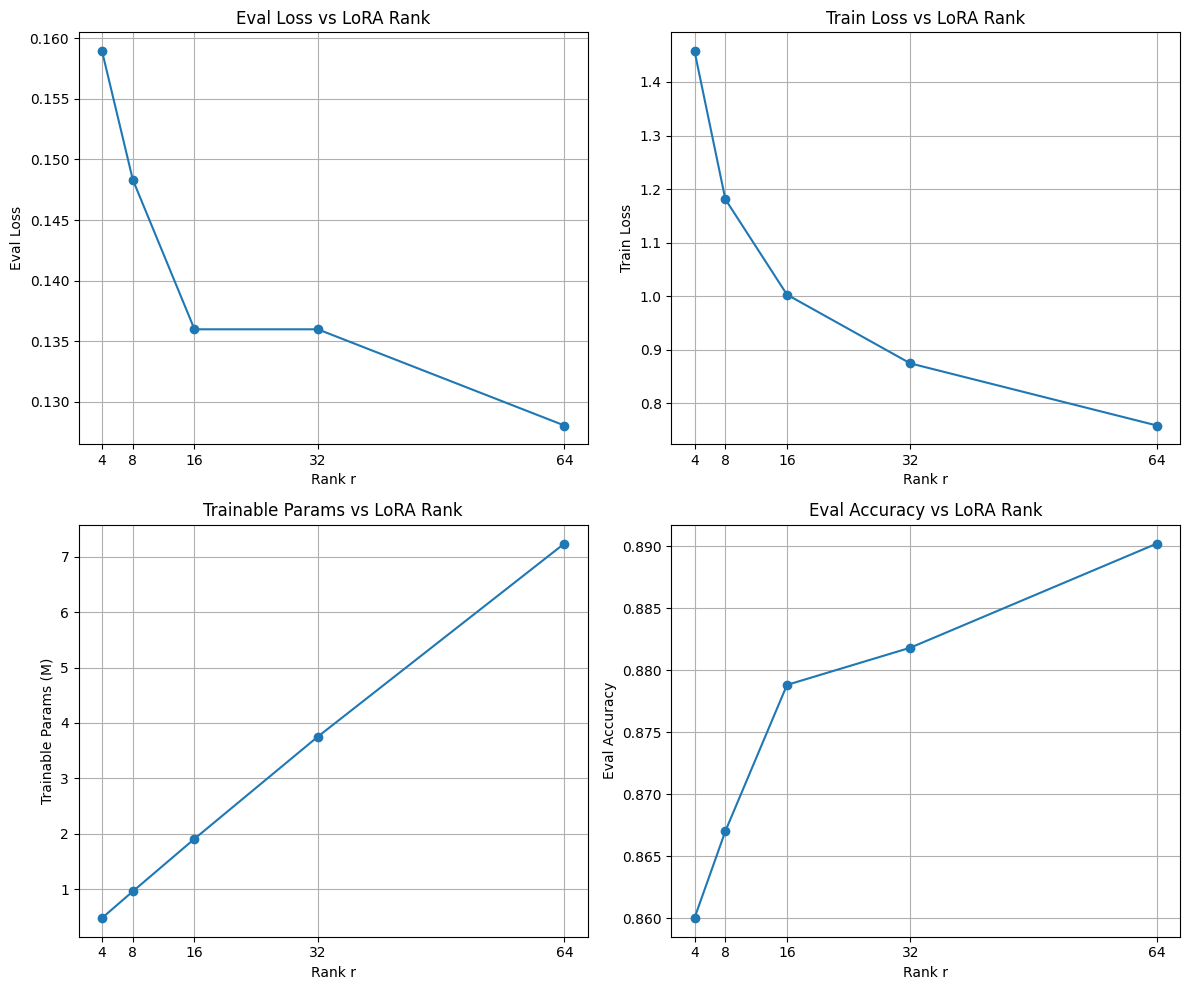

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

order = [4, 8, 16, 32, 64]

results = pd.DataFrame(results)

# Ensure ordering
results["r"] = results["r"].astype(int)
results["r"] = pd.Categorical(results["r"], categories=order, ordered=True)
results = results.sort_values("r")

# --- 4 subplots in 2 × 2 layout ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top-left: Eval Loss
axes[0, 0].plot(results["r"], results["eval_loss"], marker="o")
axes[0, 0].set_title("Eval Loss vs LoRA Rank")
axes[0, 0].set_xlabel("Rank r")
axes[0, 0].set_ylabel("Eval Loss")
axes[0, 0].grid(True)
axes[0, 0].set_xticks(order)

# Top-right: Train Loss
axes[0, 1].plot(results["r"], results["train_loss"], marker="o")
axes[0, 1].set_title("Train Loss vs LoRA Rank")
axes[0, 1].set_xlabel("Rank r")
axes[0, 1].set_ylabel("Train Loss")
axes[0, 1].grid(True)
axes[0, 1].set_xticks(order)

# Bottom-left: Trainable Params
axes[1, 0].plot(results["r"], results["trainable_params"], marker="o")
axes[1, 0].set_title("Trainable Params vs LoRA Rank")
axes[1, 0].set_xlabel("Rank r")
axes[1, 0].set_ylabel("Trainable Params (M)")
axes[1, 0].grid(True)
axes[1, 0].set_xticks(order)

# Bottom-right: Eval Accuracy
axes[1, 1].plot(results["r"], results["eval_accuracy"], marker="o")
axes[1, 1].set_title("Eval Accuracy vs LoRA Rank")
axes[1, 1].set_xlabel("Rank r")
axes[1, 1].set_ylabel("Eval Accuracy")
axes[1, 1].grid(True)
axes[1, 1].set_xticks(order)

plt.tight_layout()
plt.show()


# Final Training and Evaluation

In [12]:
from datasets import concatenate_datasets

full_train_ds = concatenate_datasets([train_ds, eval_ds])
full_train_ds = full_train_ds.shuffle(seed=42)  

In [13]:
r=32

In [14]:
model = AutoModelForSeq2SeqLM.from_pretrained(
        "google-t5/t5-small",
        dtype=torch.float16
    )
config = LoraConfig(
        r=r,
        lora_alpha=r,
        target_modules=["q", "k", "o", "v"],
        lora_dropout=0.1,
        bias="none",
    )
model = get_peft_model(model, config)


In [15]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

In [17]:
args = Seq2SeqTrainingArguments(
        "./lora_outputs_r64_full",
        learning_rate=5e-3,
        per_device_train_batch_size=128,
        gradient_accumulation_steps=4,
        gradient_checkpointing_kwargs={"use_reentrant": False},
        per_device_eval_batch_size=4,
        fp16=True,
        num_train_epochs=5,
        logging_strategy="epoch",
        label_names=["labels"],
        gradient_checkpointing=True,
        save_strategy="no",
        eval_strategy="no",
        load_best_model_at_end=True,
    )



trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=full_train_ds,
    eval_dataset=test_ds,
    processing_class=tokenizer,                 
    data_collator=data_collator,
    compute_metrics=compute_metrics,      
)


In [18]:
train_result_full = trainer.train()

print("Training Metrics (full data, r=32):", train_result_full.metrics)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/DATA405/khushi/gpt/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
17,3.071100
34,0.195100
51,0.162800
68,0.142600
85,0.138400


Training Metrics (full data, r=32): {'train_runtime': 422.6902, 'train_samples_per_second': 295.725, 'train_steps_per_second': 0.201, 'total_flos': 1.7823694848e+16, 'train_loss': 0.7419993681066176, 'epoch': 5.0}


In [19]:
torch.cuda.empty_cache()

In [21]:
from torch.utils.data import DataLoader
import torch

def evaluate_in_chunks(model, dataset, tokenizer, data_collator, chunk_size=500):
    """Evaluate in smaller chunks to avoid OOM"""
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Process in chunks
    for i in range(0, len(dataset), chunk_size):
        chunk = dataset.select(range(i, min(i + chunk_size, len(dataset))))
        
        dataloader = DataLoader(
            chunk,
            batch_size=4,
            collate_fn=data_collator
        )
        
        chunk_preds = []
        chunk_labels = []
        
        with torch.no_grad():
            for batch in dataloader:
                batch = {k: v.to(model.device) for k, v in batch.items()}
                
                # Generate predictions
                generated = model.generate(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    max_length=64,  # Adjust as needed
                    num_beams=1,    # Greedy decoding
                )
                
                chunk_preds.extend(generated.cpu())
                chunk_labels.extend(batch["labels"].cpu())
                
                del batch, generated
        
        all_preds.extend(chunk_preds)
        all_labels.extend(chunk_labels)
        
        # Clear cache after each chunk
        torch.cuda.empty_cache()
        print(f"Processed {min(i + chunk_size, len(dataset))}/{len(dataset)} samples")
    
    # Now compute metrics on CPU
    from transformers import EvalPrediction
    import numpy as np
    
    preds = np.array([p.numpy() for p in all_preds])
    labels = np.array([l.numpy() for l in all_labels])
    
    eval_pred = EvalPrediction(predictions=preds, label_ids=labels)
    metrics = compute_metrics(eval_pred)
    
    return metrics

# Use it
metrics_full = evaluate_in_chunks(model, test_ds, tokenizer, data_collator, chunk_size=500)
print("Test Metrics (full data, r=64):", metrics_full)

Processed 500/25000 samples
Processed 1000/25000 samples
Processed 1500/25000 samples
Processed 2000/25000 samples
Processed 2500/25000 samples
Processed 3000/25000 samples
Processed 3500/25000 samples
Processed 4000/25000 samples
Processed 4500/25000 samples
Processed 5000/25000 samples
Processed 5500/25000 samples
Processed 6000/25000 samples
Processed 6500/25000 samples
Processed 7000/25000 samples
Processed 7500/25000 samples
Processed 8000/25000 samples
Processed 8500/25000 samples
Processed 9000/25000 samples
Processed 9500/25000 samples
Processed 10000/25000 samples
Processed 10500/25000 samples
Processed 11000/25000 samples
Processed 11500/25000 samples
Processed 12000/25000 samples
Processed 12500/25000 samples
Processed 13000/25000 samples
Processed 13500/25000 samples
Processed 14000/25000 samples
Processed 14500/25000 samples
Processed 15000/25000 samples
Processed 15500/25000 samples
Processed 16000/25000 samples
Processed 16500/25000 samples
Processed 17000/25000 samples


Accuracy : 90.16%